# Tutorial - U-net for Semantic Image Segmentation

#### Author: Antonio Rueda-Toicen
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

In [ ]:
%%bash
pip install fiftyone==1.4.1 > /dev/null
pip install torchmetrics==1.7.1 > /dev/null


In [ ]:
# # Tutorial - Creating a U-Net Convolutional Neural Network for Semantic Image Segmentation
# (Content from original notebook remains the same until data loading)

# ## Get the data
import skimage.io as io
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms # Use v2 transforms
import torchvision.transforms.v2.functional as F_tv # Use functional API from v2
import tifffile as tiff
import random
from ipywidgets import interact
import ipywidgets as widgets
import cv2 # Still needed for saving images via cv2.imwrite in visualization
from tqdm import tqdm
import fiftyone as fo
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F_torch # PyTorch functional
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryFBetaScore
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Ensure reproducibility for transforms and splitting
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# --- Data Loading ---
images_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-train-volume.tif?raw=true'
all_labeled_images_uint8 = io.imread(images_url) # Keep original dtype for mean/std calc if needed

labels_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-train-labels.tif?raw=true'
label_images_uint8 = io.imread(labels_url)

test_images_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-test-volume.tif?raw=true'
test_images_uint8 = io.imread(test_images_url)

print("Original Shapes:")
print("Train Images:", all_labeled_images_uint8.shape, all_labeled_images_uint8.dtype)
print("Train Labels:", label_images_uint8.shape, label_images_uint8.dtype)
print("Test Images:", test_images_uint8.shape, test_images_uint8.dtype)



Original Shapes:
Train Images: (30, 512, 512) uint8
Train Labels: (30, 512, 512) uint8
Test Images: (30, 512, 512) uint8


In [ ]:
# --- Visualize Original Data ---
def visualize_original(slider_value):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(all_labeled_images_uint8[slider_value, :, :], cmap='gray')
    axes[0].set_title('Training Image')
    axes[0].axis('off')
    axes[1].imshow(label_images_uint8[slider_value, :, :], cmap='gray')
    axes[1].set_title('Label Image')
    axes[1].axis('off')
    plt.show()

slider_orig = widgets.IntSlider(min=0, max=all_labeled_images_uint8.shape[0]-1, step=1, value=16, description="Image Index")
# interact(visualize_original, slider_value=slider_orig); # Commenting out for non-interactive env

# --- Split into training and validation sets ---
dataset_size = all_labeled_images_uint8.shape[0]
validation_split = 0.3
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Use fixed indices based on seed for reproducibility
validation_indices = np.random.choice(dataset_size, validation_size, replace=False)
validation_indices.sort() # Optional: sort for consistency
all_indices = set(range(dataset_size)) # Corrected range
train_indices = np.array(sorted(list(all_indices - set(validation_indices))))

print("Validation indices:", validation_indices)
print("Train indices:", train_indices)

# Split uint8 data first
train_images_uint8 = all_labeled_images_uint8[train_indices]
valid_images_uint8 = all_labeled_images_uint8[validation_indices]
train_labels_uint8 = label_images_uint8[train_indices]
valid_labels_uint8 = label_images_uint8[validation_indices]

# --- Precompute Mean/Std for Normalization ---
# Calculate mean/std on the *training* set *after* scaling to [0, 1] float32
# This matches the original approach and how Normalize expects the mean/std
temp_train_images_float = train_images_uint8.astype(np.float32) / 255.0
train_mean = temp_train_images_float.mean()
train_std = temp_train_images_float.std()
print(f"Calculated Training Mean (0-1 scale): {train_mean:.6f}")
print(f"Calculated Training Std (0-1 scale): {train_std:.6f}")

# --- Define Transforms using torchvision.transforms.v2 ---

IMG_SIZE = 512 # Define image size

# Training Transforms
# Note: v2 transforms operate on Tensors. They handle image-mask pairs correctly.
# Geometric transforms apply to both, pixel transforms (ColorJitter, Normalize) apply only to image.
train_transform = transforms.Compose([
    # 1. Convert NumPy [0, 255] to Tensor [0, 1] Float32 for both image and mask
    # Use functional API here initially if Compose struggles with tuples directly
    # Update: Compose in v2 *should* handle (image, mask) tuple input for ToImage/ToDtype
    transforms.ToImage(), # Converts uint8 HWC/HW to CHW Tensor (does not scale)
    transforms.ToDtype(torch.float32, scale=True), # Scales to [0, 1] and converts dtype

    # 2. Augmentations (Applied jointly or image-only as appropriate)
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0, sigma=5.0)], p=0.8), # Jointly
    transforms.RandomAffine(
        degrees=(-180, 180),        # Rotation
        translate=(0.1, 0.1),       # Shift (relative to image size)
        scale=(0.9, 1.1),           # Scale
        shear=None,                 # No shear in original Albumentations setup
        fill=0                      # Fill with black for pixels outside boundary
    ), # Jointly, p=1.0 implicitly, apply RandomApply if prob needed
    transforms.RandomHorizontalFlip(p=0.5), # Jointly
    transforms.RandomVerticalFlip(p=0.5),   # Jointly
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Image only, apply RandomApply if prob needed

    # 3. Resize (ensure consistent size after augmentations)
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE), antialias=True), # Jointly

    # 4. Normalization (Applied image-only AFTER all other transforms)
    # We will apply this manually in the Dataset's __getitem__
])

# Validation/Test Transforms (Minimal: Convert, Resize, Normalize)
valid_test_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE), antialias=True),
    # Normalization applied manually in __getitem__
])

# Normalization Transform (applied separately)
normalize_transform = transforms.Normalize(mean=[train_mean], std=[train_std])


# --- Define Torchvision Dataset ---

class TorchvisionTIFDataset(Dataset):
    """Dataset class using torchvision.transforms.v2"""
    def __init__(self, images_np, masks_np, transform=None, normalize=None):
        """
        Args:
            images_np (numpy.ndarray): Numpy array of images (N, H, W), uint8 [0, 255]
            masks_np (numpy.ndarray): Numpy array of masks (N, H, W), uint8 [0, 255]
            transform (callable, optional): A torchvision.transforms.v2 Compose object for augmentations/preprocessing.
            normalize (callable, optional): A torchvision.transforms.v2 Normalize object.
        """
        self.images = images_np
        self.masks = masks_np
        self.transform = transform
        self.normalize = normalize

        if self.images.shape[0] != self.masks.shape[0]:
             raise ValueError("Number of images and masks must be the same.")
        if self.images.ndim != 3 or self.masks.ndim != 3:
            raise ValueError("Images and masks should be 3D arrays (N, H, W).")


    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        # Get raw image and mask as numpy arrays (H, W)
        image_np = self.images[idx] # Shape (H, W), dtype uint8
        mask_np = self.masks[idx]   # Shape (H, W), dtype uint8

        # Apply the main transformations (handles ToTensor, augmentations, resize)
        # Pass as a tuple for joint geometric transforms
        if self.transform:
            # v2 transforms expect (image, target) where target can be mask
            image_t, mask_t = self.transform(image_np, mask_np)
            # Output should be Tensors (C, H, W), float32 [0, 1]
        else:
             # Manual conversion if no transform provided (unlikely case)
             image_t = F_tv.to_image(image_np)
             image_t = F_tv.to_dtype(image_t, torch.float32, scale=True)
             mask_t = F_tv.to_image(mask_np)
             mask_t = F_tv.to_dtype(mask_t, torch.float32, scale=True) # Keep mask 0-1


        # Apply normalization ONLY to the image
        if self.normalize:
            image_t = self.normalize(image_t)

        # Ensure mask remains single channel and suitable format for loss (e.g., float32)
        # BCEWithLogitsLoss expects target shape matching output shape (N, C, H, W) or (N, H, W)
        # Our mask_t is likely (1, H, W), float32 after transforms. This should be okay.
        # If mask has values other than 0 or 1 after interpolation/transforms, clamp or threshold if needed.
        # mask_t = torch.clamp(mask_t, 0.0, 1.0) # Clamp if needed

        return image_t, mask_t


# --- Create Datasets and DataLoaders ---

# Use the uint8 numpy arrays
train_dataset = TorchvisionTIFDataset(
    train_images_uint8, train_labels_uint8,
    transform=train_transform,
    normalize=normalize_transform
)

val_dataset = TorchvisionTIFDataset(
    valid_images_uint8, valid_labels_uint8,
    transform=valid_test_transform, # Use non-augmenting transform
    normalize=normalize_transform
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Example: Get one item to check shapes and types
img_sample, msk_sample = train_dataset[0]
print("Sample shapes:", img_sample.shape, msk_sample.shape) # Should be [1, IMG_SIZE, IMG_SIZE]
print("Sample types:", img_sample.dtype, msk_sample.dtype)   # Should be torch.float32
print("Sample image range:", img_sample.min().item(), img_sample.max().item()) # Should be normalized
print("Sample mask range:", msk_sample.min().item(), msk_sample.max().item())   # Should be [0, 1]


# --- Visualization of Augmented Data (Modified) ---

def save_augmented_dataset_tv(dataset, output_dir, n_samples_per_original=5):
    """Save augmented images and masks using Torchvision for visualization"""
    images_out_dir = os.path.join(output_dir, "images")
    masks_out_dir = os.path.join(output_dir, "masks")
    os.makedirs(images_out_dir, exist_ok=True)
    os.makedirs(masks_out_dir, exist_ok=True)

    # Get the training transform *without* normalization for better visualization
    viz_train_transform = transforms.Compose([
        t for t in dataset.transform.transforms # Access the list of transforms
        if not isinstance(t, transforms.Normalize) # Exclude Normalize
    ])
    # We also need ToImage and ToDtype which were part of the original transform
    # Let's rebuild it cleanly for visualization
    viz_train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True), # Scale to 0-1 for saving
        transforms.RandomApply([transforms.ElasticTransform(alpha=50.0, sigma=5.0)], p=0.8),
        transforms.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE), antialias=True),
    ])


    num_saved = 0
    # Iterate through original images in the dataset's source numpy arrays
    for img_idx in tqdm(range(len(dataset.images)), desc="Generating augmented samples"):
        original_image_np = dataset.images[img_idx] # uint8 (H, W)
        original_mask_np = dataset.masks[img_idx]   # uint8 (H, W)

        # Save original image and mask (scaled to 0-255)
        cv2.imwrite(
            os.path.join(images_out_dir, f"original_{img_idx}.png"),
            original_image_np
        )
        cv2.imwrite(
            os.path.join(masks_out_dir, f"original_{img_idx}.png"),
            original_mask_np # Save mask as grayscale 0/255
        )
        num_saved += 2

        # Generate multiple augmentations using the viz transform
        for aug_idx in range(n_samples_per_original):
            # Apply augmentation (outputs tensors 0-1)
            aug_image_t, aug_mask_t = viz_train_transform(original_image_np, original_mask_np)

            # Convert Tensors (C, H, W), float32 [0, 1] back to NumPy uint8 [0, 255] (H, W) for saving
            # Image
            aug_image_np = aug_image_t.squeeze(0).cpu().numpy() # Remove C=1 dim -> (H, W)
            aug_image_np = (aug_image_np * 255).astype(np.uint8)

            # Mask
            aug_mask_np = aug_mask_t.squeeze(0).cpu().numpy() # Remove C=1 dim -> (H, W)
            aug_mask_np = (aug_mask_np * 255).astype(np.uint8) # Scale 0-1 mask back to 0-255

            # Save augmented image and mask
            cv2.imwrite(
                os.path.join(images_out_dir, f"aug_{img_idx}_{aug_idx}.png"),
                aug_image_np
            )
            cv2.imwrite(
                os.path.join(masks_out_dir, f"aug_{img_idx}_{aug_idx}.png"),
                aug_mask_np
            )
            num_saved += 2

    print(f"Saved {num_saved // 2} image/mask pairs ({num_saved} total files) to {output_dir}")


def create_fiftyone_dataset(augmented_dir, dataset_name="u-net-augmentations-tv"):
    """Create a FiftyOne dataset to visualize the augmented images and masks"""
    # Check if dataset exists and delete
    if fo.dataset_exists(dataset_name):
        print(f"Deleting existing dataset '{dataset_name}'...")
        fo.delete_dataset(dataset_name)

    dataset = fo.Dataset(dataset_name)
    image_dir = os.path.join(augmented_dir, "images")
    mask_dir = os.path.join(augmented_dir, "masks")
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    for image_filename in tqdm(image_files, desc="Adding to FiftyOne dataset"):
        mask_filename = image_filename
        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        if not os.path.exists(mask_path):
            print(f"Warning: Mask file not found for {image_filename}, skipping sample.")
            continue

        is_augmented = "aug_" in image_filename
        sample = fo.Sample(filepath=image_path)
        sample["segmentation"] = fo.Segmentation(mask_path=mask_path) # Load mask
        sample["is_augmented"] = is_augmented

        try:
            if is_augmented:
                parts = image_filename.replace("aug_", "").replace(".png", "").split("_")
                if len(parts) == 2:
                    img_idx, aug_idx = map(int, parts)
                    sample["original_image_idx"] = img_idx
                    sample["augmentation_idx"] = aug_idx
                else:
                     print(f"Warning: Could not parse indices from augmented filename {image_filename}")
            else:
                img_idx_str = image_filename.replace("original_", "").replace(".png", "")
                sample["original_image_idx"] = int(img_idx_str)
        except ValueError:
             print(f"Warning: Could not parse integer index from filename {image_filename}")


        dataset.add_sample(sample)

    print(f"Created FiftyOne dataset '{dataset_name}' with {len(dataset)} samples")
    return dataset


def setup_unet_augmentations_tv():
    # Create datasets (already done above, reusing train_dataset and val_dataset)

    # Save augmented dataset for FiftyOne visualization
    output_dir = 'augmented_dataset_tv' # New directory for torchvision version
    save_augmented_dataset_tv(train_dataset, output_dir, n_samples_per_original=5)

    # Create FiftyOne dataset
    fo_dataset = create_fiftyone_dataset(output_dir, dataset_name="u-net-augmentations-tv")

    # Launch the FiftyOne App (optional, can be slow in some environments)
    try:
        session = fo.launch_app(fo_dataset, auto=False)
        print(f"FiftyOne App launched at: {session.url}")
        # session.open_tab() # Opens automatically if auto=True (default) or manually here
    except Exception as e:
        print(f"Could not launch FiftyOne app automatically: {e}")
        print("You can launch it manually by running `fiftyone app launch u-net-augmentations-tv` in your terminal.")
        session = None


    # Create DataLoaders
    # Use num_workers for faster loading if possible
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True) # Can use larger batch for validation

    return train_loader, val_loader, session

# Run the setup
train_loader, valid_loader, fo_session = setup_unet_augmentations_tv()

# --- Defining the U-net model ---
# (U-Net class definition remains exactly the same as the original code)
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), # Bias False because BN follows
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Input channels to DoubleConv needs to accommodate concatenated channels
            self.conv = DoubleConv(in_channels // 2 + out_channels, out_channels, in_channels // 2) # Adjusted DoubleConv input
            # Correction: The original U-Net paper (and common implementations) DoubleConv
            # after upsampling takes `in_channels` (from skip connection) + `out_channels` (from upsampled path)
            # Let's rethink the channel counts.
            # After upsampling x5 (512 channels), it has 512 channels.
            # x4 has 512 channels. Concatenated: 1024.
            # The DoubleConv should process these 1024 channels down to `out_channels`.
            # So, DoubleConv input should be in_channels (from below) + num_skip_channels
            # In the original code: Up(1024, 256). If bilinear=True, self.up keeps 512 channels.
            # self.conv input was `in_channels` (1024), output `out_channels` (256). THIS IS WRONG.
            # Let's fix Up's DoubleConv input channels based on concatenation.
            # Skip connection channels = out_channels of the corresponding Down block.
            # Upsampled channels = in_channels // 2 if ConvTranspose, or remains same if Upsample only changes spatial dim.
            # Let's assume `in_channels` to Up is the number of channels *before* upsampling (e.g., 1024 for up1).
            # Let's assume `out_channels` is the desired output channels *after* DoubleConv (e.g., 256 for up1).
            # The corresponding skip connection has `out_channels` (e.g., x4 has 512 for up1). NO, x4 has 512, not 256.
            # Let's trace UNet forward pass:
            # x1: 64
            # x2: 128 (from down1)
            # x3: 256 (from down2)
            # x4: 512 (from down3)
            # x5: 512 (from down4)
            # up1(x5, x4): x5 upsampled (512 ch), concat x4 (512 ch) -> 1024 ch input to DoubleConv -> output 256 ch (out_channels)
            # up2(up1_out, x3): up1_out upsampled (256 ch), concat x3 (256 ch) -> 512 ch input to DoubleConv -> output 128 ch
            # up3(up2_out, x2): up2_out upsampled (128 ch), concat x2 (128 ch) -> 256 ch input to DoubleConv -> output 64 ch
            # up4(up3_out, x1): up3_out upsampled (64 ch), concat x1 (64 ch) -> 128 ch input to DoubleConv -> output 64 ch
            # So, DoubleConv in Up needs `num_upsampled_channels + num_skip_channels` as input.
            num_skip_channels = out_channels * 2 # e.g., for up1, out=256, skip=x4=512. NO, this logic is flawed.
            # Let's use the structure from the original code and assume the arguments mean:
            # Up(channels_from_lower_layer, channels_from_skip_connection) -> output channels = channels_from_skip_connection ? No.
            # Let's use the original definition: Up(in_ch, out_ch) where in_ch is channels *after* concat, out_ch is final output channels.
            # BUT the original instantiation used Up(1024, 256), etc. which implies in_ch is combined channels.
            # Let's assume `in_channels` is the combined channel dimension, `out_channels` is the target dim.
            # If bilinear: upsample preserves channels (in_channels // 2). Concatenated with skip (also in_channels // 2?), -> in_channels total?
            # Let's stick to the original code's implementation detail:
            self.conv = DoubleConv(in_channels, out_channels) # Assumes in_channels = channels_upsampled + channels_skip
        else:
            # If not bilinear, ConvTranspose halves the channels during upsampling
            self.up = nn.ConvTranspose2d(in_channels // 2 , in_channels // 2, kernel_size=2, stride=2)
            # After concat: (in_channels // 2 from upsample) + (in_channels // 2 from skip?) -> in_channels
            self.conv = DoubleConv(in_channels, out_channels) # Same input assumption

    def forward(self, x_lower, x_skip):
        """
        x_lower: tensor from the lower layer (to be upsampled)
        x_skip: tensor from the skip connection (encoder path)
        """
        x_up = self.up(x_lower)

        # Handle potential size mismatch after upsampling vs skip connection
        # Input is B, C, H, W
        diffY = x_skip.size()[2] - x_up.size()[2]
        diffX = x_skip.size()[3] - x_up.size()[3]

        # Pad x_up to match x_skip dimensions
        # Padding format: (pad_left, pad_right, pad_top, pad_bottom)
        x_up = F_torch.pad(x_up, [diffX // 2, diffX - diffX // 2,
                                  diffY // 2, diffY - diffY // 2])

        # Concatenate along the channel dimension (dim=1)
        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)




Validation indices: [ 8  9 12 15 17 23 24 27 28]
Train indices: [ 0  1  2  3  4  5  6  7 10 11 13 14 16 18 19 20 21 22 25 26 29]
Calculated Training Mean (0-1 scale): 0.498608
Calculated Training Std (0-1 scale): 0.171884
Train dataset size: 21
Validation dataset size: 9
Sample shapes: torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
Sample types: torch.float32 torch.float32
Sample image range: -2.9008431434631348 2.917041540145874
Sample mask range: 0.0 1.0


Generating augmented samples: 100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Saved 126 image/mask pairs (252 total files) to augmented_dataset_tv


Adding to FiftyOne dataset: 100%|██████████| 126/126 [00:00<00:00, 722.47it/s]


Created FiftyOne dataset 'u-net-augmentations-tv' with 126 samples
Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.4.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.4.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



FiftyOne App launched at: https://5151-gpu-t4-hm-36nkcldqpljz5-c.asia-east1-1.prod.colab.dev?polling=true


In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True): # Added bilinear flag
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1 # Factor for ConvTranspose halving channels
        self.down4 = Down(512, 1024 // factor) # Last down layer output channels

        # Correct channel numbers for Up layers based on concat logic:
        # up1 combines upsampled(down4 out) + skip(down3 out) -> inputs to conv = (1024//f) + 512
        # up2 combines upsampled(up1 out) + skip(down2 out) -> inputs to conv = 512 + 256
        # up3 combines upsampled(up2 out) + skip(down1 out) -> inputs to conv = 256 + 128
        # up4 combines upsampled(up3 out) + skip(inc out) -> inputs to conv = 128 + 64
        # Output channels of Up layers typically halve at each stage from bottom up.
        self.up1 = Up(1024, 512 // factor, bilinear) # In: 512(up)+512(skip)=1024. Out: 512//f
        self.up2 = Up(512, 256 // factor, bilinear)  # In: 256(up)+256(skip)=512. Out: 256//f
        self.up3 = Up(256, 128 // factor, bilinear)  # In: 128(up)+128(skip)=256. Out: 128//f
        self.up4 = Up(128, 64, bilinear)             # In: 64(up)+64(skip)=128. Out: 64
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits




In [ ]:
# --- Training ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model (using bilinear upsampling by default)
# n_classes=1 for binary segmentation (cell body vs background)
model = UNet(n_channels=1, n_classes=1, bilinear=True).to(device)

# Loss and Optimizer
# BCEWithLogitsLoss is suitable for binary (n_classes=1) output + sigmoid activation handled internally
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Consider AdamW or learning rate scheduler

# Training Loop (modified slightly for clarity and metrics)
def train_model_tv(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = None # Store best weights

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in pbar_train:
            inputs = inputs.to(device) # Shape: [B, 1, H, W]
            labels = labels.to(device) # Shape: [B, 1, H, W], float32 [0, 1]

            optimizer.zero_grad()
            outputs = model(inputs) # Shape: [B, 1, H, W], logits

            # Ensure labels have the same dtype as outputs for loss calculation if needed
            # BCEWithLogitsLoss handles logits, expects float targets
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            pbar_train.set_postfix(loss=loss.item())

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in pbar_val:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                pbar_val.set_postfix(loss=loss.item())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Save best model based on validation loss
        if epoch_val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.4f} --> {epoch_val_loss:.4f}). Saving model...")
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            # Optional: Save checkpoint to file
            # torch.save(model.state_dict(), 'unet_best_model_tv.pth')

    print('Finished Training')

    # Load best model weights back
    if best_model_wts:
        print(f"Loading best model weights with Val Loss: {best_val_loss:.4f}")
        model.load_state_dict(best_model_wts)
    else:
         print("Warning: No best model weights found (validation loss might not have improved).")


    # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (BCEWithLogits)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model




Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s, loss=0.735]


Epoch 1/50 - Train Loss: 0.5244, Val Loss: 0.7400
Validation loss decreased (inf --> 0.7400). Saving model...


Epoch 2/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s, loss=0.67]


Epoch 2/50 - Train Loss: 0.4197, Val Loss: 0.9225


Epoch 3/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s, loss=1.22]


Epoch 3/50 - Train Loss: 0.3853, Val Loss: 1.9479


Epoch 4/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s, loss=0.403]


Epoch 4/50 - Train Loss: 0.3727, Val Loss: 0.4041
Validation loss decreased (0.7400 --> 0.4041). Saving model...


Epoch 5/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s, loss=0.408]


Epoch 5/50 - Train Loss: 0.3817, Val Loss: 0.3900
Validation loss decreased (0.4041 --> 0.3900). Saving model...


Epoch 6/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s, loss=0.392]


Epoch 6/50 - Train Loss: 0.3399, Val Loss: 0.3672
Validation loss decreased (0.3900 --> 0.3672). Saving model...


Epoch 7/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s, loss=0.29]


Epoch 7/50 - Train Loss: 0.3449, Val Loss: 0.3138
Validation loss decreased (0.3672 --> 0.3138). Saving model...


Epoch 8/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s, loss=0.346]


Epoch 8/50 - Train Loss: 0.3528, Val Loss: 0.3600


Epoch 9/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s, loss=0.399]


Epoch 9/50 - Train Loss: 0.3909, Val Loss: 0.3977


Epoch 10/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s, loss=0.3]


Epoch 10/50 - Train Loss: 0.3845, Val Loss: 0.3154


Epoch 11/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s, loss=0.325]


Epoch 11/50 - Train Loss: 0.3460, Val Loss: 0.3201


Epoch 12/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, loss=0.277]


Epoch 12/50 - Train Loss: 0.3883, Val Loss: 0.2958
Validation loss decreased (0.3138 --> 0.2958). Saving model...


Epoch 13/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s, loss=0.297]


Epoch 13/50 - Train Loss: 0.3528, Val Loss: 0.3046


Epoch 14/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, loss=0.255]


Epoch 14/50 - Train Loss: 0.3854, Val Loss: 0.2731
Validation loss decreased (0.2958 --> 0.2731). Saving model...


Epoch 15/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s, loss=0.275]


Epoch 15/50 - Train Loss: 0.3277, Val Loss: 0.2864


Epoch 16/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s, loss=0.238]


Epoch 16/50 - Train Loss: 0.3457, Val Loss: 0.2721
Validation loss decreased (0.2731 --> 0.2721). Saving model...


Epoch 17/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s, loss=0.236]


Epoch 17/50 - Train Loss: 0.3123, Val Loss: 0.2636
Validation loss decreased (0.2721 --> 0.2636). Saving model...


Epoch 18/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s, loss=0.226]


Epoch 18/50 - Train Loss: 0.3352, Val Loss: 0.2537
Validation loss decreased (0.2636 --> 0.2537). Saving model...


Epoch 19/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s, loss=0.261]


Epoch 19/50 - Train Loss: 0.3558, Val Loss: 0.2697


Epoch 20/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s, loss=0.236]


Epoch 20/50 - Train Loss: 0.3162, Val Loss: 0.2591


Epoch 21/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s, loss=0.225]


Epoch 21/50 - Train Loss: 0.3387, Val Loss: 0.2495
Validation loss decreased (0.2537 --> 0.2495). Saving model...


Epoch 22/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s, loss=0.23]


Epoch 22/50 - Train Loss: 0.3342, Val Loss: 0.2526


Epoch 23/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s, loss=0.234]


Epoch 23/50 - Train Loss: 0.3231, Val Loss: 0.2557


Epoch 24/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s, loss=0.235]


Epoch 24/50 - Train Loss: 0.3464, Val Loss: 0.2566


Epoch 25/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s, loss=0.22]


Epoch 25/50 - Train Loss: 0.2879, Val Loss: 0.2404
Validation loss decreased (0.2495 --> 0.2404). Saving model...


Epoch 26/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s, loss=0.216]


Epoch 26/50 - Train Loss: 0.3534, Val Loss: 0.2447


Epoch 27/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s, loss=0.262]


Epoch 27/50 - Train Loss: 0.3585, Val Loss: 0.2703


Epoch 28/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s, loss=0.246]


Epoch 28/50 - Train Loss: 0.3296, Val Loss: 0.2563


Epoch 29/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s, loss=0.225]


Epoch 29/50 - Train Loss: 0.2692, Val Loss: 0.2411


Epoch 30/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s, loss=0.236]


Epoch 30/50 - Train Loss: 0.3425, Val Loss: 0.2523


Epoch 31/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s, loss=0.223]


Epoch 31/50 - Train Loss: 0.3411, Val Loss: 0.2461


Epoch 32/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s, loss=0.234]


Epoch 32/50 - Train Loss: 0.3533, Val Loss: 0.2486


Epoch 33/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s, loss=0.243]


Epoch 33/50 - Train Loss: 0.3786, Val Loss: 0.2589


Epoch 34/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s, loss=0.211]


Epoch 34/50 - Train Loss: 0.2877, Val Loss: 0.2397
Validation loss decreased (0.2404 --> 0.2397). Saving model...


Epoch 35/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s, loss=0.22]


Epoch 35/50 - Train Loss: 0.2966, Val Loss: 0.2382
Validation loss decreased (0.2397 --> 0.2382). Saving model...


Epoch 36/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s, loss=0.21]


Epoch 36/50 - Train Loss: 0.3092, Val Loss: 0.2262
Validation loss decreased (0.2382 --> 0.2262). Saving model...


Epoch 37/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s, loss=0.21]


Epoch 37/50 - Train Loss: 0.3125, Val Loss: 0.2295


Epoch 38/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s, loss=0.232]


Epoch 38/50 - Train Loss: 0.3020, Val Loss: 0.2403


Epoch 39/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s, loss=0.218]


Epoch 39/50 - Train Loss: 0.3107, Val Loss: 0.2335


Epoch 40/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s, loss=0.226]


Epoch 40/50 - Train Loss: 0.3016, Val Loss: 0.2380


Epoch 41/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s, loss=0.226]


Epoch 41/50 - Train Loss: 0.3235, Val Loss: 0.2425


Epoch 42/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s, loss=0.208]


Epoch 42/50 - Train Loss: 0.3415, Val Loss: 0.2258
Validation loss decreased (0.2262 --> 0.2258). Saving model...


Epoch 43/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s, loss=0.227]


Epoch 43/50 - Train Loss: 0.3510, Val Loss: 0.2430


Epoch 44/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s, loss=0.221]


Epoch 44/50 - Train Loss: 0.2781, Val Loss: 0.2392


Epoch 45/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s, loss=0.224]


Epoch 45/50 - Train Loss: 0.3337, Val Loss: 0.2373


Epoch 46/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s, loss=0.213]


Epoch 46/50 - Train Loss: 0.3397, Val Loss: 0.2255
Validation loss decreased (0.2258 --> 0.2255). Saving model...


Epoch 47/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s, loss=0.224]


Epoch 47/50 - Train Loss: 0.3121, Val Loss: 0.2303


Epoch 48/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s, loss=0.214]


Epoch 48/50 - Train Loss: 0.3124, Val Loss: 0.2311


Epoch 49/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s, loss=0.229]


Epoch 49/50 - Train Loss: 0.3092, Val Loss: 0.2396


Epoch 50/50 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s, loss=0.224]


Epoch 50/50 - Train Loss: 0.3054, Val Loss: 0.2390
Finished Training
Loading best model weights with Val Loss: 0.2255


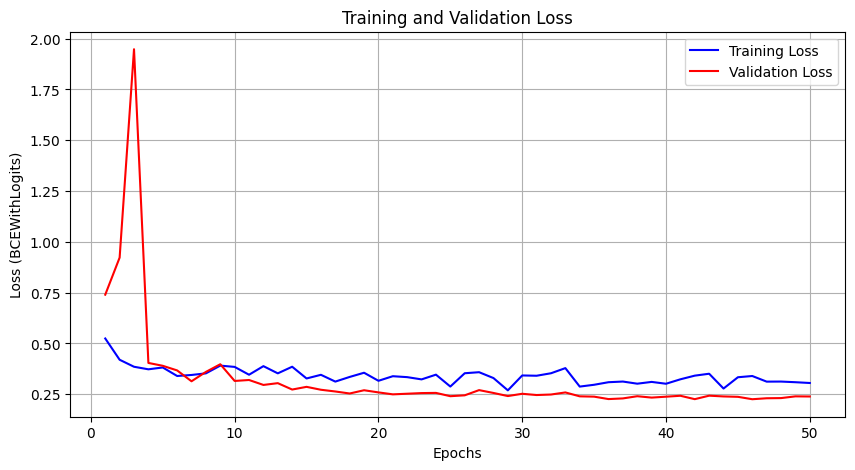

interactive(children=(IntSlider(value=0, description='Image Index (Batch)', max=3), FloatSlider(value=0.5, des…

In [ ]:
# Start training
NUM_EPOCHS = 50 # As in original
trained_model = train_model_tv(model, train_loader, valid_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=device)

# --- Compute performance metrics and select threshold ---

# Get a batch from validation loader for analysis
val_iter = iter(valid_loader)
images_val_batch, labels_val_batch = next(val_iter) # B, C, H, W

# Predict on the validation batch
trained_model.eval()
with torch.no_grad():
    logits_pred_val = trained_model(images_val_batch.to(device))
    probs_pred_val = torch.sigmoid(logits_pred_val) # Convert logits to probabilities B, C, H, W

# Detach from GPU and move to CPU for analysis/plotting
images_val_batch_cpu = images_val_batch.cpu()
labels_val_batch_cpu = labels_val_batch.cpu() # Already float32 [0, 1]
probs_pred_val_cpu = probs_pred_val.cpu()


# --- Interactive Visualization of Predictions and Threshold ---
def visualize_predictions_tv(slider_value, threshold_value):
    # slider_value selects the image within the batch (0 to batch_size-1)
    img_idx_in_batch = slider_value

    # Inverse normalize the input image for display
    # Need mean and std used for normalization
    mean = torch.tensor([train_mean]).view(1, 1, 1)
    std = torch.tensor([train_std]).view(1, 1, 1)
    input_image = images_val_batch_cpu[img_idx_in_batch] * std + mean
    input_image = torch.clamp(input_image, 0, 1) # Clamp to [0, 1] range
    input_image_np = input_image.squeeze(0).numpy() # Remove C dim -> (H, W)

    # Probability map (already [0, 1])
    probs_image = probs_pred_val_cpu[img_idx_in_batch].squeeze(0).numpy() # (H, W)

    # Binarized prediction
    binarized_image = (probs_image > threshold_value).astype(np.uint8) # Convert to 0/1 int

    # Ground truth label
    ground_truth_label = labels_val_batch_cpu[img_idx_in_batch].squeeze(0).numpy() # (H, W), float32 [0, 1]
    ground_truth_int = ground_truth_label.astype(np.uint8) # Convert to 0/1 int for CM

    # --- Plotting ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Image index in batch: {img_idx_in_batch}, Threshold: {threshold_value:.2f}", fontsize=14)

    axes[0, 0].imshow(input_image_np, cmap='gray')
    axes[0, 0].set_title('Input Image (Un-normalized)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(probs_image, cmap='viridis') # Use viridis for probabilities
    axes[0, 1].set_title('Prediction Probability Map')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(binarized_image, cmap='gray')
    axes[0, 2].set_title('Binarized Prediction')
    axes[0, 2].axis('off')

    # Ground Truth Label
    axes[1, 0].imshow(ground_truth_int, cmap='gray')
    axes[1, 0].set_title('Ground Truth Label')
    axes[1, 0].axis('off')

    # Probability Histogram
    axes[1, 1].hist(probs_image.flatten(), bins=50, color='blue', alpha=0.7, range=(0, 1))
    axes[1, 1].set_title('Probability Distribution')
    axes[1, 1].set_xlabel('Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(threshold_value, color='r', linestyle='dashed', linewidth=1)

    # Confusion Matrix
    try:
        cm = confusion_matrix(ground_truth_int.flatten(), binarized_image.flatten(), labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # Display CM using seaborn heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2], cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        axes[1, 2].set_title('Confusion Matrix')
        axes[1, 2].set_xlabel('Predicted Label')
        axes[1, 2].set_ylabel('True Label')

        # Print CM values below plot for clarity
        print("-" * 30)
        print(f"Confusion Matrix (Threshold: {threshold_value:.2f}):")
        print(f"  True Negatives (TN): {tn}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Positives (TP): {tp}")
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print("-" * 30)

    except ValueError as e:
        axes[1, 2].text(0.5, 0.5, f'CM Error:\n{e}', ha='center', va='center')
        print(f"Could not compute Confusion Matrix: {e}")
        print("Ground truth range:", ground_truth_int.min(), ground_truth_int.max())
        print("Predicted range:", binarized_image.min(), binarized_image.max())


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


# Widgets for interaction
slider_value_widget = widgets.IntSlider(min=0, max=images_val_batch_cpu.shape[0]-1, step=1,
                                        value=0, description="Image Index (Batch)")
threshold_value_widget = widgets.FloatSlider(min=0.01, max=0.99, step=0.01,
                                             value=0.5, description="Threshold")

interact(visualize_predictions_tv, slider_value=slider_value_widget,
         threshold_value=threshold_value_widget);




Evaluating on Validation Set: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Calculating metrics for different thresholds...


Thresholds: 100%|██████████| 99/99 [00:01<00:00, 52.47it/s]



Metrics DataFrame Head:
   precision    recall        f1     fbeta  threshold
0   0.783911  1.000000  0.878868  0.794003       0.01
1   0.784644  0.999989  0.879324  0.794711       0.02
2   0.787291  0.999957  0.880971  0.797265       0.03
3   0.791690  0.999874  0.883686  0.801506       0.04
4   0.796964  0.999732  0.886906  0.806587       0.05


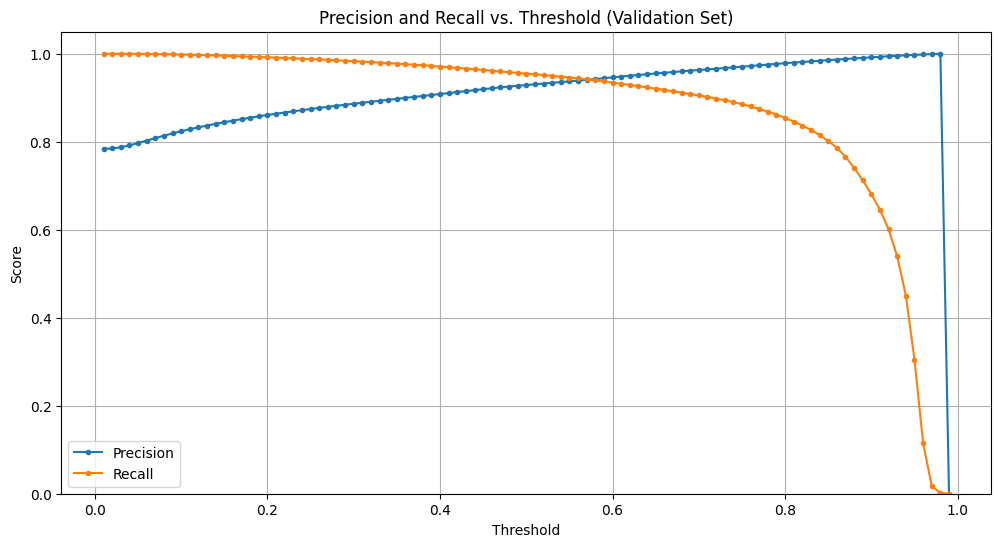

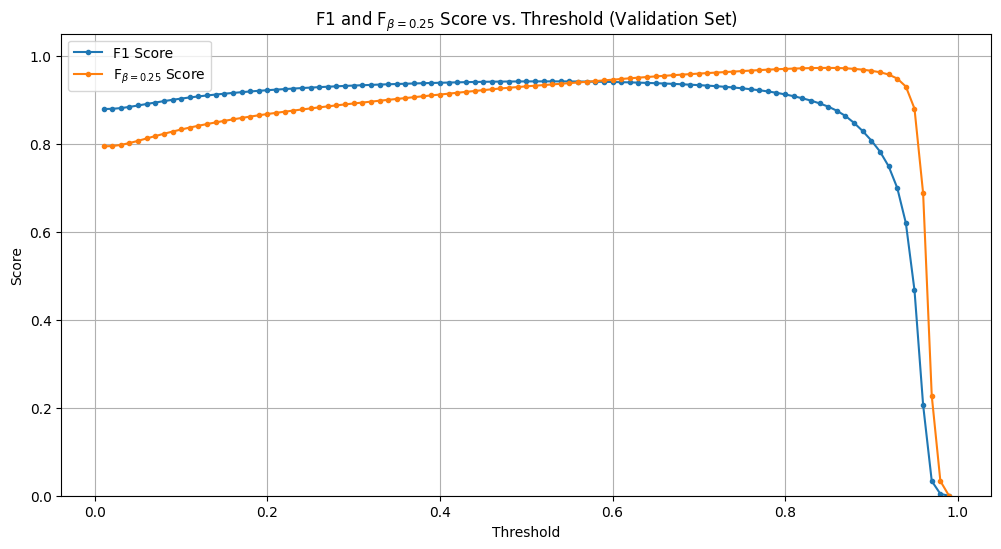


Best Threshold based on F1 Score:
precision    0.932185
recall       0.951453
f1           0.941721
fbeta        0.933297
threshold    0.520000
Name: 51, dtype: float64

Best Threshold based on F-beta (beta=0.25) Score:
precision    0.985407
recall       0.801987
f1           0.884286
fbeta        0.972326
threshold    0.850000
Name: 84, dtype: float64
Test dataset size: 30
Test image tensor shape: torch.Size([1, 1, 512, 512])


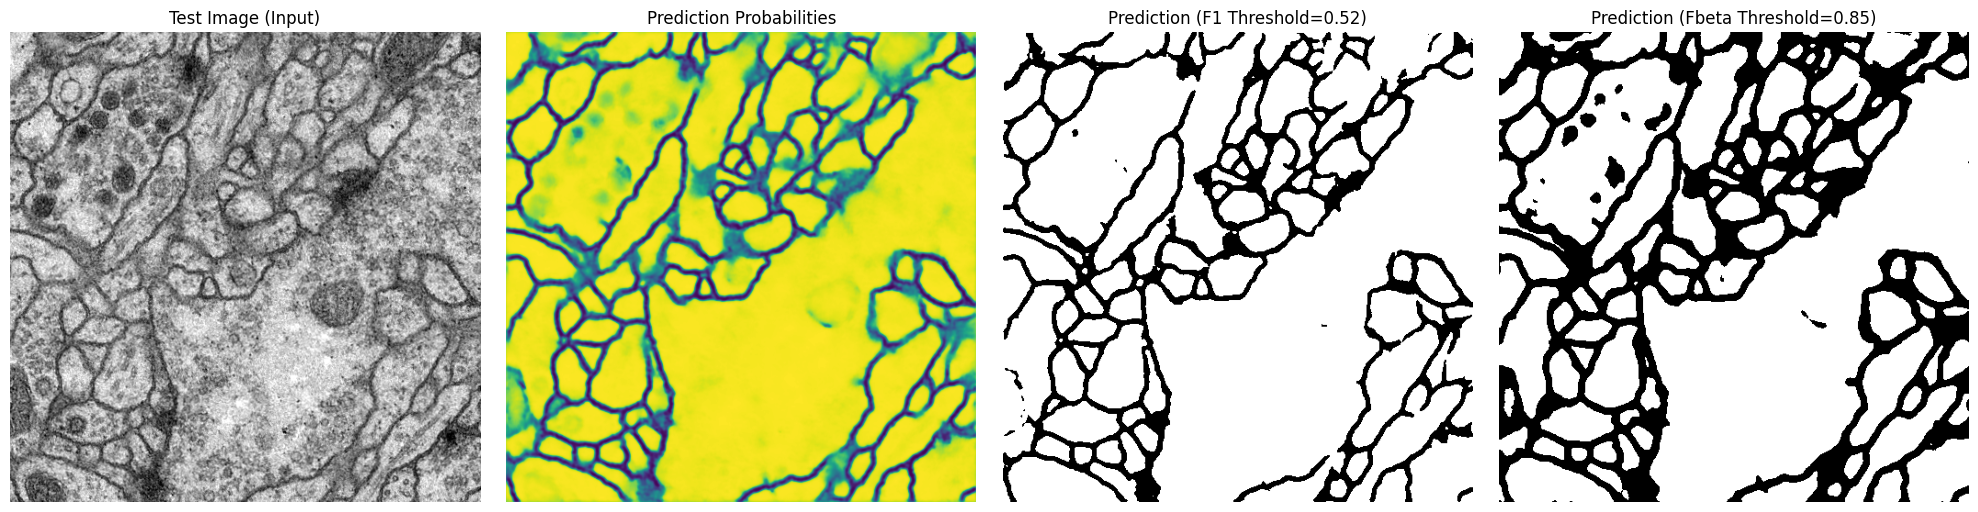

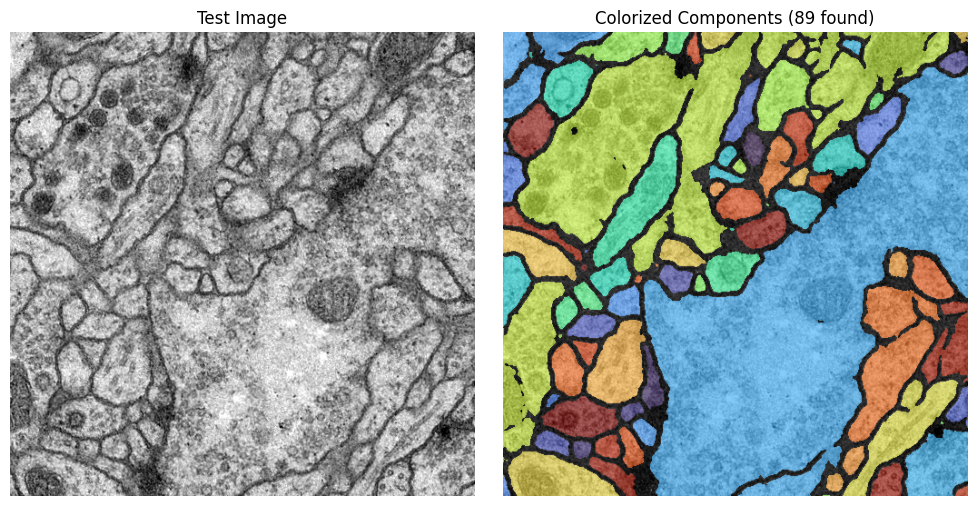

In [ ]:
# --- Calculate Metrics across Thresholds ---

# Initialize metrics (use .to(device) inside the loop)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)
f1_metric = BinaryF1Score().to(device)
fbeta_metric = BinaryFBetaScore(beta=0.25).to(device) # F-beta with beta=0.25

thresholds = np.arange(0.01, 1.0, 0.01)
metrics_results = {'precision': [], 'recall': [], 'f1': [], 'fbeta': [], 'threshold': []}

# Evaluate on the *entire* validation set
trained_model.eval()
with torch.no_grad():
    # Collect all predictions and labels first
    all_probs_val = []
    all_labels_val = []
    pbar_eval = tqdm(valid_loader, desc="Evaluating on Validation Set")
    for inputs, labels in pbar_eval:
        inputs = inputs.to(device)
        labels = labels.to(device) # Keep labels on device (int type needed for metrics)
        logits_pred = trained_model(inputs)
        probs_pred = torch.sigmoid(logits_pred)

        all_probs_val.append(probs_pred.cpu()) # Move probs to CPU for thresholding later
        all_labels_val.append(labels.int().cpu()) # Move labels to CPU, ensure int type

    # Concatenate all batches
    all_probs_val_tensor = torch.cat(all_probs_val, dim=0)
    all_labels_val_tensor = torch.cat(all_labels_val, dim=0)

    # Iterate through thresholds
    print("Calculating metrics for different thresholds...")
    for t in tqdm(thresholds, desc="Thresholds"):
        # Binarize predictions based on threshold
        preds_binarized = (all_probs_val_tensor >= t).int().to(device) # Binarized predictions on device
        labels_int = all_labels_val_tensor.to(device) # True labels on device

        # Calculate metrics (ensure preds and labels are on the same device)
        prec = precision_metric(preds_binarized, labels_int).item()
        rec = recall_metric(preds_binarized, labels_int).item()
        f1 = f1_metric(preds_binarized, labels_int).item()
        f_bet = fbeta_metric(preds_binarized, labels_int).item()

        metrics_results['precision'].append(prec)
        metrics_results['recall'].append(rec)
        metrics_results['f1'].append(f1)
        metrics_results['fbeta'].append(f_bet)
        metrics_results['threshold'].append(t)

scores_df = pd.DataFrame(metrics_results)
print("\nMetrics DataFrame Head:")
print(scores_df.head())

# --- Plot Metrics vs Threshold ---
plt.figure(figsize=(12, 6))
plt.plot(scores_df['threshold'], scores_df['precision'], label='Precision', marker='.', linestyle='-')
plt.plot(scores_df['threshold'], scores_df['recall'], label='Recall', marker='.', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold (Validation Set)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_df['threshold'], scores_df['f1'], label='F1 Score', marker='.', linestyle='-')
plt.plot(scores_df['threshold'], scores_df['fbeta'], label=r'F$_{\beta=0.25}$ Score', marker='.', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(r'F1 and F$_{\beta=0.25}$ Score vs. Threshold (Validation Set)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

# Find optimal thresholds
idx_max_f1 = scores_df['f1'].idxmax()
max_f1_row = scores_df.loc[idx_max_f1]
print("\nBest Threshold based on F1 Score:")
print(max_f1_row)

idx_max_fbeta = scores_df['fbeta'].idxmax()
max_fbeta_row = scores_df.loc[idx_max_fbeta]
print("\nBest Threshold based on F-beta (beta=0.25) Score:")
print(max_fbeta_row)


# --- Testing (without Ground Truth Labels) ---

# Define Test Dataset (using uint8 numpy array)
class TestTIFDatasetTV(Dataset):
    def __init__(self, test_images_np, transform=None, normalize=None):
        """
        Args:
            test_images_np (numpy.ndarray): Numpy array of test images (N, H, W), uint8
            transform (callable, optional): torchvision transform for preprocessing (e.g., resize)
            normalize (callable, optional): torchvision normalize transform
        """
        self.images = test_images_np
        self.transform = transform
        self.normalize = normalize
        if self.images.ndim != 3:
            raise ValueError("Test images should be a 3D array (N, H, W).")

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image_np = self.images[idx] # (H, W), uint8

        # Apply main transform (ToTensor, Resize)
        if self.transform:
            # Pass only image, as there's no mask target
            image_t = self.transform(image_np) # Handles ToImage, ToDtype, Resize
        else:
            # Manual conversion if needed
            image_t = F_tv.to_image(image_np)
            image_t = F_tv.to_dtype(image_t, torch.float32, scale=True)

        # Apply normalization
        if self.normalize:
            image_t = self.normalize(image_t)

        return image_t


# Create Test Dataset and DataLoader
test_dataset = TestTIFDatasetTV(test_images_uint8,
                                transform=valid_test_transform, # Use same non-augmenting as validation
                                normalize=normalize_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

print(f"Test dataset size: {len(test_dataset)}")

# Get one test image
test_img_tensor = next(iter(test_dataloader))
print(f"Test image tensor shape: {test_img_tensor.shape}") # Should be [1, 1, H, W]

# Run inference on the test image using the trained model
trained_model.eval()
with torch.no_grad():
    test_logits = trained_model(test_img_tensor.to(device))
    test_probs = torch.sigmoid(test_logits).cpu() # Get probabilities [0, 1] on CPU

# --- Visualize Test Results with Different Thresholds ---
test_img_display = test_img_tensor.squeeze(0).squeeze(0).numpy() # Original test image (normalized)
test_probs_np = test_probs.squeeze(0).squeeze(0).numpy() # Probability map

# Inverse normalize the test image for display
mean = torch.tensor([train_mean]).view(1, 1, 1)
std = torch.tensor([train_std]).view(1, 1, 1)
test_img_unnorm = test_img_tensor.cpu() * std.cpu() + mean.cpu()
test_img_unnorm = torch.clamp(test_img_unnorm, 0, 1).squeeze().numpy()


# Apply thresholds found during validation
pred_f1_thresh = (test_probs_np >= max_f1_row['threshold']).astype(np.uint8)
pred_fbeta_thresh = (test_probs_np >= max_fbeta_row['threshold']).astype(np.uint8)

# Plot test image and predictions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(test_img_unnorm, cmap='gray')
axes[0].set_title('Test Image (Input)')
axes[0].axis('off')

axes[1].imshow(test_probs_np, cmap='viridis')
axes[1].set_title('Prediction Probabilities')
axes[1].axis('off')

axes[2].imshow(pred_f1_thresh, cmap='gray')
axes[2].set_title(f'Prediction (F1 Threshold={max_f1_row["threshold"]:.2f})')
axes[2].axis('off')

axes[3].imshow(pred_fbeta_thresh, cmap='gray')
axes[3].set_title(f'Prediction (Fbeta Threshold={max_fbeta_row["threshold"]:.2f})')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# --- Extra: Colorize Connected Components ---
# (Code remains the same as it uses scipy/matplotlib, not Albumentations)
import scipy.ndimage as ndi
from matplotlib.colors import ListedColormap

def colorize_labels(labels):
    labeled_array, num_features = ndi.label(labels)
    print(f"Found {num_features} connected components.")
    return labeled_array

def create_custom_cmap(num_labels):
    # Create a colormap with enough distinct colors, ensuring 0 is black
    # Use a perceptually uniform colormap like 'turbo' or 'viridis' and sample from it
    # Or stick to tab20/tab20b if num_labels is small
    if num_labels <= 20:
        cmap_base = plt.colormaps.get_cmap('tab20')
        colors = cmap_base(np.linspace(0, 1, num_labels + 1)) # Get colors including for background
    else:
        # Use a continuous map like turbo for more components
        cmap_base = plt.colormaps.get_cmap('turbo')
        colors = cmap_base(np.linspace(0, 1, num_labels + 1))

    colors[0] = [0, 0, 0, 1]  # Set the color for label 0 (background) to black
    # Optional: Shuffle colors (except black) for better visual distinction
    if num_labels > 1:
        perm = np.random.permutation(num_labels) + 1 # Indices 1 to num_labels
        colors[1:] = colors[perm]

    return ListedColormap(colors)

# Visualize on the test prediction using F1 threshold
labeled_prediction, num_components = ndi.label(pred_f1_thresh)
custom_cmap = create_custom_cmap(num_components)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img_unnorm, cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_img_unnorm, cmap='gray') # Base image
plt.imshow(labeled_prediction, cmap=custom_cmap, alpha=0.6) # Overlay colored components
plt.title(f'Colorized Components ({num_components} found)')
plt.axis('off')
plt.tight_layout()
plt.show()

